# Re-Run Analyses with Polka et. al. Subset

This notebook was created in response to Polka et al. Group's inquiry on training a logistic regression model on preprints posted recently rather than preprints from 2019 and below.
Overall their subset can be separated with a few features.

In [1]:
from pathlib import Path
import sys

from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import plotnine as p9
import requests
from scipy.spatial.distance import cdist
from scipy.stats import linregress
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import spacy
import tqdm

from annorxiver_modules.document_helper import generate_doc_vector

mpl.rcParams["figure.dpi"] = 250

# Random BioRxiv Sample

In [2]:
manual_papers_df = pd.read_csv(str(Path("output/all_pairs_2021-02-11.csv")))
manual_papers_df.head().T

,0,1,2,3,4
Unnamed: 0,1,2,3,4,5
line_break_and_label,(((((( Preprint DOI:,(((((( Preprint DOI:,(((((( Preprint DOI:,(((((( Preprint DOI:,(((((( Preprint DOI:
source,medrxiv,medrxiv,medrxiv,medrxiv,medrxiv
doi,10.1101/19005710,10.1101/19006031,10.1101/19006171,10.1101/19006478,10.1101/19006502
abstract_source,crossref,copied,copied,copied,crossref
line_break_version,((((((,((((((,((((((,((((((,((((((
n_versions,1,2,2,2,1
line_break_and_fiducial,(((((( We have manually inserted this sentence...,(((((( We have manually inserted this sentence...,(((((( We have manually inserted this sentence...,(((((( We have manually inserted this sentence...,(((((( We have manually inserted this sentence...
posted_date,########,########,########,########,########
covid_preprint,False,False,False,False,False


In [3]:
api_url = "https://api.biorxiv.org/details/biorxiv/2020-01-01/2020-04-30"
response = requests.get(api_url)
content = response.json()
total_papers = content["messages"][0]["total"]
total_papers

16281

In [4]:
np.random.seed(100)
selected_biorxiv_papers = np.random.randint(0, total_papers, 100)
selected_biorxiv_papers.sort()
selected_biorxiv_papers

array([    2,    79,   350,   488,   802,   806,   889,  1340,  1667,
        1738,  1900,  2240,  2434,  2526,  2630,  2883,  2992,  3213,
        3253,  3408,  3419,  3767,  3949,  3998,  4109,  4149,  4227,
        4231,  4369,  4376,  4533,  4713,  4859,  4993,  5305,  5640,
        5646,  5769,  5787,  5843,  6212,  6230,  6901,  6936,  7074,
        7096,  7221,  7406,  7738,  7906,  8039,  8209,  8466,  8810,
        9220,  9428,  9619,  9723,  9741,  9871, 10082, 10091, 10303,
       10412, 10557, 10602, 10655, 10843, 10933, 10992, 11152, 11207,
       11492, 11567, 11695, 11969, 12088, 12119, 12219, 12571, 12900,
       13070, 13297, 13681, 13772, 13890, 13896, 14147, 14212, 14218,
       14260, 14291, 14385, 14811, 15182, 15360, 15390, 15453, 16039,
       16079])

In [5]:
paper_cursor = {}
for paper in selected_biorxiv_papers:
    cursor = int(np.ceil(int(paper / 100)))
    if cursor not in paper_cursor:
        paper_cursor[cursor] = []
    paper_cursor[cursor].append(paper)
paper_cursor

{0: [2, 79],
 3: [350],
 4: [488],
 8: [802, 806, 889],
 13: [1340],
 16: [1667],
 17: [1738],
 19: [1900],
 22: [2240],
 24: [2434],
 25: [2526],
 26: [2630],
 28: [2883],
 29: [2992],
 32: [3213, 3253],
 34: [3408, 3419],
 37: [3767],
 39: [3949, 3998],
 41: [4109, 4149],
 42: [4227, 4231],
 43: [4369, 4376],
 45: [4533],
 47: [4713],
 48: [4859],
 49: [4993],
 53: [5305],
 56: [5640, 5646],
 57: [5769, 5787],
 58: [5843],
 62: [6212, 6230],
 69: [6901, 6936],
 70: [7074, 7096],
 72: [7221],
 74: [7406],
 77: [7738],
 79: [7906],
 80: [8039],
 82: [8209],
 84: [8466],
 88: [8810],
 92: [9220],
 94: [9428],
 96: [9619],
 97: [9723, 9741],
 98: [9871],
 100: [10082, 10091],
 103: [10303],
 104: [10412],
 105: [10557],
 106: [10602, 10655],
 108: [10843],
 109: [10933, 10992],
 111: [11152],
 112: [11207],
 114: [11492],
 115: [11567],
 116: [11695],
 119: [11969],
 120: [12088],
 121: [12119],
 122: [12219],
 125: [12571],
 129: [12900],
 130: [13070],
 132: [13297],
 136: [13681],
 13

In [6]:
published_doi_map = []
for paper in tqdm.tqdm(paper_cursor):
    api_url = f"https://api.biorxiv.org/details/biorxiv/2020-01-01/2020-04-30/{paper}"
    response = requests.get(api_url)
    content = response.json()
    collection = content["collection"]

    for paper_idx in paper_cursor[paper]:
        user_doi = collection[paper_idx % 100]["doi"]
        file_name = user_doi.split("/")[-1]

        api_url = f"https://api.biorxiv.org/details/biorxiv/{user_doi}"
        response = requests.get(api_url)
        content = response.json()

        latest_paper = content["collection"][-1]
        version_count = len(content["collection"])

        doc_url = "http://biorxiv.org/content"
        file_url = f"{doc_url}/early/{latest_paper['date'].replace('-', '/')}/{file_name}.source.xml"
        response = requests.get(file_url)

        with open(
            f"output/biorxiv_xml_files_recent/{file_name}_v{version_count}.xml", "wb"
        ) as outfile:
            outfile.write(response.content)

100%|██████████| 76/76 [02:16<00:00,  1.79s/it]


# Document Embeddings

## Convert New biorxiv subset

In [7]:
biorxiv_documents = [
    Path(x.name) for x in list(Path("output/biorxiv_xml_files_recent").rglob("*xml"))
]

In [8]:
biorxiv_xpath_str = "//abstract/p|//abstract/title|//body/sec//p|//body/sec//title"
word_model = Word2Vec.load(
    str(Path("../word_vector_experiment/output/word2vec_models/300/biorxiv_300.model"))
)

In [9]:
biorxiv_document_map = {
    document: generate_doc_vector(
        word_model,
        document_path=str(Path("output/biorxiv_xml_files_recent") / document),
        xpath=biorxiv_xpath_str,
    )
    for document in tqdm.tqdm_notebook(biorxiv_documents)
}

In [10]:
biorxiv_vec_df = (
    pd.DataFrame.from_dict(biorxiv_document_map, orient="index")
    .rename(columns={col: f"feat_{col}" for col in range(int(300))})
    .rename_axis("document")
    .reset_index()
)

biorxiv_vec_df.to_csv(
    "output/random_recent_biorxiv_subset_embeddings.tsv", sep="\t", index=False
)

biorxiv_vec_df.head().T

,0,1,2,3,4
document,321604_v2.xml,376939_v3.xml,256107_v3.xml,373704_v2.xml,349415_v5.xml
feat_0,-0.114518,-0.063533,0.221019,0.302259,0.051775
feat_1,0.353949,-0.023293,0.275567,0.206131,0.176325
feat_2,-0.482558,-0.31079,-0.724086,-0.267682,-0.288674
feat_3,-0.152574,0.0718906,-0.158742,-0.16236,-0.124129
...,...,...,...,...,...
feat_295,0.00284993,-0.370227,-0.269455,0.0713695,-0.136429
feat_296,0.244742,0.16237,-0.0674481,0.28867,0.306565
feat_297,0.53427,0.533277,0.331405,0.481021,0.203033
feat_298,-0.126256,-0.528269,-0.416591,-0.424362,-0.162116


## Load the Documents

In [11]:
polka_preprints_df = pd.read_csv("output/polka_et_al_biorxiv_embeddings.tsv", sep="\t")
polka_preprints_df.head()

,document,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_290,feat_291,feat_292,feat_293,feat_294,feat_295,feat_296,feat_297,feat_298,feat_299
0,838870_v1.xml,-0.236496,-0.158390,-0.137343,-0.001011,-0.284048,-0.271869,0.041991,0.120466,0.264844,...,0.125062,-0.135080,0.170882,-0.308521,-0.600287,-0.345592,0.039640,0.730110,-0.348575,0.372932
1,2020.02.13.945485_v1.xml,-0.209540,0.062120,-0.013421,-0.000279,-0.314423,-0.326985,0.110545,0.243373,0.338386,...,-0.119528,0.035750,-0.064431,-0.094898,-0.711048,-0.044813,0.324615,0.655335,-0.402705,0.460434
2,2020.01.13.905190_v1.xml,0.229247,0.103720,-0.675217,-0.279651,0.141527,-0.414926,-0.125090,0.169768,0.501925,...,0.282492,0.042949,0.182784,-0.178214,-0.292325,0.067889,0.266495,0.434768,-0.672433,0.628961
3,865089_v1.xml,0.259484,0.187865,-0.476495,0.104272,-0.239906,-0.327997,0.087983,0.278655,0.548521,...,0.273547,0.442512,0.137913,-0.376542,-0.662379,-0.009104,0.152630,0.026150,-0.478900,0.473070
4,832675_v1.xml,0.331504,0.397300,-0.662221,-0.082239,0.142704,-0.483719,-0.225434,0.289693,0.750071,...,0.357520,0.031200,0.369862,-0.425790,-0.461598,-0.768766,0.229174,0.504789,-0.708815,0.094324


In [12]:
pca_components = pd.read_csv(
    Path("../pca_association_experiment/output/word_pca_similarity/pca_components.tsv"),
    sep="\t",
)
pca_components.head()

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,-0.049104,-0.022952,0.054169,0.054761,0.035576,-0.010399,-0.024812,-0.048933,0.017739,0.088210,...,-0.074235,-0.055353,-0.008411,0.026470,-0.026992,-0.032384,0.035687,0.070615,-0.018170,-0.097132
1,-0.025294,0.025114,0.044676,-0.124849,-0.057298,0.006263,0.074133,0.061397,-0.021857,-0.091527,...,-0.007480,0.028617,-0.049084,0.024782,-0.013106,-0.007171,0.008073,0.068401,0.101262,0.096735
2,0.034591,0.073876,0.081714,-0.064158,-0.041002,0.021764,0.103048,-0.014965,0.015615,0.116552,...,-0.013544,0.064324,-0.055909,-0.069447,-0.112860,-0.091762,0.000651,0.036475,0.057296,-0.083348
3,-0.049435,-0.079498,0.022533,0.082681,-0.078703,-0.024764,0.031693,0.042404,-0.034200,0.026995,...,-0.001326,-0.103326,0.053888,-0.101415,0.046668,-0.087855,-0.108510,0.035366,-0.099735,-0.005285
4,-0.089308,0.008366,-0.053669,-0.040672,0.089469,0.001333,-0.082718,-0.011179,0.005334,-0.017407,...,0.053544,-0.001412,0.052857,0.052416,-0.038935,-0.116536,-0.033255,0.131235,0.050803,-0.013997


## PCA Components

This section aims to see which principal components have a high association with Polka et al's subset. Furthermore, we also aim to see if we can use linear models to explain which PCs affect preprint prediction.

In [13]:
document_pca_sim = 1 - cdist(
    polka_preprints_df.drop("document", axis=1).values, pca_components.values, "cosine"
)
print(document_pca_sim.shape)
document_pca_sim

(60, 50)


array([[ 0.48535459,  0.32769718, -0.11702601, ..., -0.00708894,
        -0.1763098 ,  0.07093126],
       [ 0.40229859,  0.40125141, -0.11295513, ..., -0.02142173,
        -0.17558446,  0.03351737],
       [-0.13201049,  0.00422107, -0.23458851, ..., -0.05661229,
        -0.17898195,  0.03952835],
       ...,
       [ 0.0705537 , -0.05343738, -0.11530624, ..., -0.05205647,
        -0.16128802,  0.08376136],
       [ 0.45579515,  0.07217712,  0.10180552, ..., -0.02012594,
        -0.17641599,  0.04301979],
       [-0.14215926,  0.01035352, -0.30403885, ...,  0.00640834,
        -0.16529912,  0.07293628]])

In [14]:
document_to_pca_map = {
    document: document_pca_sim[idx, :]
    for idx, document in enumerate(polka_preprints_df.document.tolist())
}

In [15]:
polka_pca_sim_df = (
    pd.DataFrame.from_dict(document_to_pca_map, orient="index")
    .rename(index=str, columns={col: f"pc{col+1}" for col in range(int(300))})
    .reset_index()
    .rename(index=str, columns={"index": "document"})
)
# polka_pca_sim_df.to_csv("output/polka_pca_enrichment.tsv", sep="\t")
polka_pca_sim_df = polka_pca_sim_df.assign(label="polka")
polka_pca_sim_df.head()

,document,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,label
0,838870_v1.xml,0.485355,0.327697,-0.117026,0.060002,0.082892,-0.231834,0.197279,0.070949,0.119728,...,-0.069344,0.165091,-0.035076,0.041742,-0.171587,-0.054242,-0.007089,-0.176310,0.070931,polka
1,2020.02.13.945485_v1.xml,0.402299,0.401251,-0.112955,-0.007803,0.054732,-0.152136,0.128697,0.066135,0.106593,...,-0.055381,0.137845,-0.052355,-0.007101,-0.126582,-0.095786,-0.021422,-0.175584,0.033517,polka
2,2020.01.13.905190_v1.xml,-0.132010,0.004221,-0.234589,-0.219427,0.206070,-0.214871,0.319344,-0.104184,-0.028459,...,-0.079103,0.145765,-0.021315,0.017914,-0.155084,-0.097257,-0.056612,-0.178982,0.039528,polka
3,865089_v1.xml,-0.003473,-0.226553,0.008652,-0.157976,-0.058406,-0.240677,0.286005,0.124532,0.017155,...,-0.108278,0.208805,-0.014241,0.049448,-0.196724,-0.040389,-0.031915,-0.173311,0.086573,polka
4,832675_v1.xml,0.005197,-0.018107,-0.089304,-0.150317,0.281778,-0.286903,0.368157,-0.105521,0.043050,...,-0.042351,0.151861,-0.028407,0.018610,-0.126058,-0.075546,0.045653,-0.168079,0.083449,polka


In [16]:
document_pca_sim = 1 - cdist(
    biorxiv_vec_df.drop("document", axis=1).values,
    pca_components.values,
    "cosine",
)
print(document_pca_sim.shape)
document_pca_sim

(74, 50)


array([[ 0.03202009,  0.11962647, -0.16695992, ..., -0.01338483,
        -0.17737171,  0.03715297],
       [ 0.19274486,  0.1519857 , -0.21791274, ..., -0.03250626,
        -0.18773981,  0.03282527],
       [-0.03057935,  0.03781428, -0.02814589, ..., -0.04658781,
        -0.14764248,  0.06209115],
       ...,
       [ 0.57199143, -0.15012309, -0.02644923, ..., -0.01710938,
        -0.15845058,  0.04350903],
       [ 0.40195953,  0.01458395,  0.0162907 , ..., -0.00965923,
        -0.13303648,  0.02259394],
       [ 0.24856016,  0.30886461, -0.37668466, ..., -0.00842267,
        -0.16493068,  0.04493187]])

In [17]:
document_to_pca_map = {
    document: document_pca_sim[idx, :]
    for idx, document in enumerate(biorxiv_vec_df.document.tolist())
}

In [18]:
biorxiv_pca_sim_df = (
    pd.DataFrame.from_dict(document_to_pca_map, orient="index")
    .rename(index=str, columns={col: f"pc{col+1}" for col in range(int(300))})
    .reset_index()
    .rename(index=str, columns={"index": "document"})
    .assign(label="biorxiv")
)
biorxiv_pca_sim_df.head()

,document,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,label
0,321604_v2.xml,0.032020,0.119626,-0.166960,-0.405968,0.253554,-0.287010,0.197133,-0.009703,0.061430,...,-0.033787,0.124830,-0.054840,0.019155,-0.202314,-0.064605,-0.013385,-0.177372,0.037153,biorxiv
1,376939_v3.xml,0.192745,0.151986,-0.217913,-0.059070,0.197502,-0.311386,0.215890,-0.079664,0.039883,...,-0.048525,0.133873,-0.033675,-0.007416,-0.171811,-0.061970,-0.032506,-0.187740,0.032825,biorxiv
2,256107_v3.xml,-0.030579,0.037814,-0.028146,-0.351516,0.039833,-0.251821,0.519532,0.154035,0.034799,...,-0.054116,0.103426,-0.003867,0.005198,-0.130017,-0.073569,-0.046588,-0.147642,0.062091,biorxiv
3,373704_v2.xml,0.113265,0.186771,-0.180751,-0.271600,0.037633,-0.336843,0.223808,-0.041387,0.030354,...,-0.096980,0.148627,-0.042745,0.046098,-0.131651,-0.080420,-0.035129,-0.160824,0.055057,biorxiv
4,349415_v5.xml,0.261575,0.013965,0.028157,-0.434844,0.054292,-0.246647,0.259777,0.143476,0.046964,...,-0.072870,0.119270,-0.040492,-0.007151,-0.157239,-0.049926,0.011799,-0.143142,0.039208,biorxiv


## PC Regression

### Logistic Regression

Goal here is to determine if we can figure out which PCs separate the bioRxiv subset from Polka et al.'s subset. Given that their dataset is only 60 papers we downsampled our dataset to contain only 60 papers.

In [19]:
dataset_df = biorxiv_pca_sim_df.append(polka_pca_sim_df)
dataset_df.head()

,document,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,...,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,label
0,321604_v2.xml,0.032020,0.119626,-0.166960,-0.405968,0.253554,-0.287010,0.197133,-0.009703,0.061430,...,-0.033787,0.124830,-0.054840,0.019155,-0.202314,-0.064605,-0.013385,-0.177372,0.037153,biorxiv
1,376939_v3.xml,0.192745,0.151986,-0.217913,-0.059070,0.197502,-0.311386,0.215890,-0.079664,0.039883,...,-0.048525,0.133873,-0.033675,-0.007416,-0.171811,-0.061970,-0.032506,-0.187740,0.032825,biorxiv
2,256107_v3.xml,-0.030579,0.037814,-0.028146,-0.351516,0.039833,-0.251821,0.519532,0.154035,0.034799,...,-0.054116,0.103426,-0.003867,0.005198,-0.130017,-0.073569,-0.046588,-0.147642,0.062091,biorxiv
3,373704_v2.xml,0.113265,0.186771,-0.180751,-0.271600,0.037633,-0.336843,0.223808,-0.041387,0.030354,...,-0.096980,0.148627,-0.042745,0.046098,-0.131651,-0.080420,-0.035129,-0.160824,0.055057,biorxiv
4,349415_v5.xml,0.261575,0.013965,0.028157,-0.434844,0.054292,-0.246647,0.259777,0.143476,0.046964,...,-0.072870,0.119270,-0.040492,-0.007151,-0.157239,-0.049926,0.011799,-0.143142,0.039208,biorxiv


In [20]:
model = LogisticRegressionCV(
    cv=10, Cs=100, max_iter=1000, penalty="l1", solver="liblinear"
)
model.fit(
    StandardScaler().fit_transform(dataset_df[[f"pc{idx+1}" for idx in range(50)]]),
    dataset_df["label"],
)

LogisticRegressionCV(Cs=100, cv=10, max_iter=1000, penalty='l1',
                     solver='liblinear')

In [21]:
best_result = list(filter(lambda x: x[1] == model.C_, enumerate(model.Cs_)))[0]
print(best_result)

(44, 0.3593813663804629)


In [22]:
print("Best CV Fold")
print(model.scores_["polka"][:, best_result[0]])
model.scores_["polka"][:, best_result[0]].mean()

Best CV Fold
[0.71428571 0.71428571 0.71428571 0.85714286 0.84615385 0.69230769
 0.76923077 0.69230769 0.84615385 0.61538462]


0.7461538461538462

In [23]:
model_weights_df = pd.DataFrame.from_dict(
    {
        "weight": model.coef_[0],
        "pc": list(range(1, 51)),
    }
)
model_weights_df["pc"] = pd.Categorical(model_weights_df["pc"])
model_weights_df.head()

,weight,pc
0,-0.770727,1
1,0.136223,2
2,0.000000,3
3,0.291909,4
4,0.000000,5


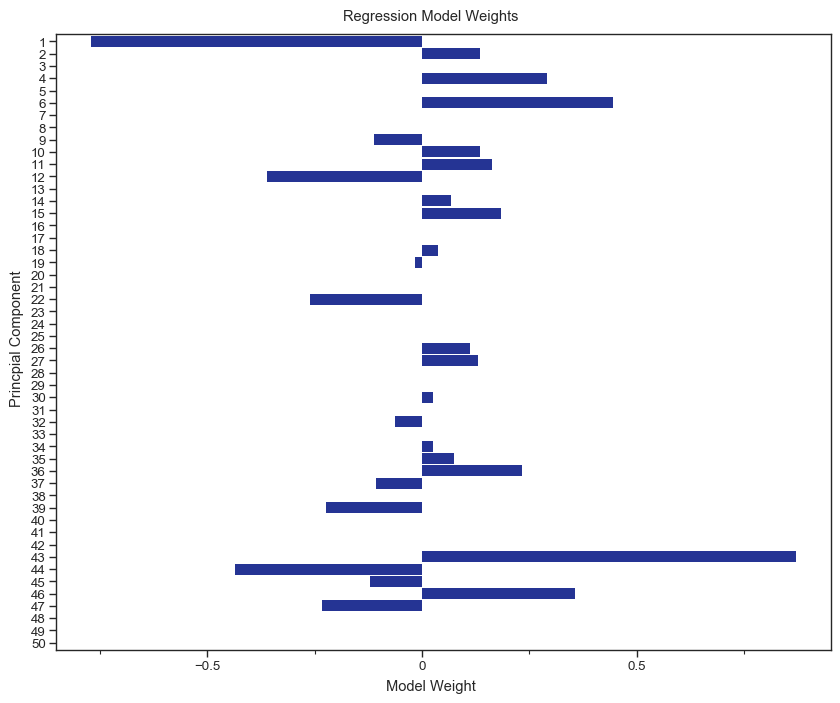

<ggplot: (8773000559343)>


In [24]:
g = (
    p9.ggplot(model_weights_df, p9.aes(x="pc", y="weight"))
    + p9.geom_col(position=p9.position_dodge(width=5), fill="#253494")
    + p9.coord_flip()
    + p9.scale_x_discrete(limits=list(sorted(range(1, 51), reverse=True)))
    + p9.theme_seaborn(context="paper", style="ticks", font_scale=1.1, font="Arial")
    + p9.theme(figure_size=(10, 8))
    + p9.labs(
        title="Regression Model Weights", x="Princpial Component", y="Model Weight"
    )
)
# g.save("output/figures/pca_log_regression_weights.svg")
# g.save("output/figures/pca_log_regression_weights.png", dpi=250)
print(g)

In [25]:
fold_features = model.coefs_paths_["polka"].transpose(1, 0, 2)
model_performance_df = pd.DataFrame.from_dict(
    {
        "feat_num": ((fold_features.astype(bool).sum(axis=1)) > 0).sum(axis=1),
        "C": model.Cs_,
        "score": model.scores_["polka"].mean(axis=0),
    }
)
model_performance_df.head()

,feat_num,C,score
0,0,0.000100,0.551648
1,0,0.000120,0.551648
2,0,0.000145,0.551648
3,0,0.000175,0.551648
4,0,0.000210,0.551648


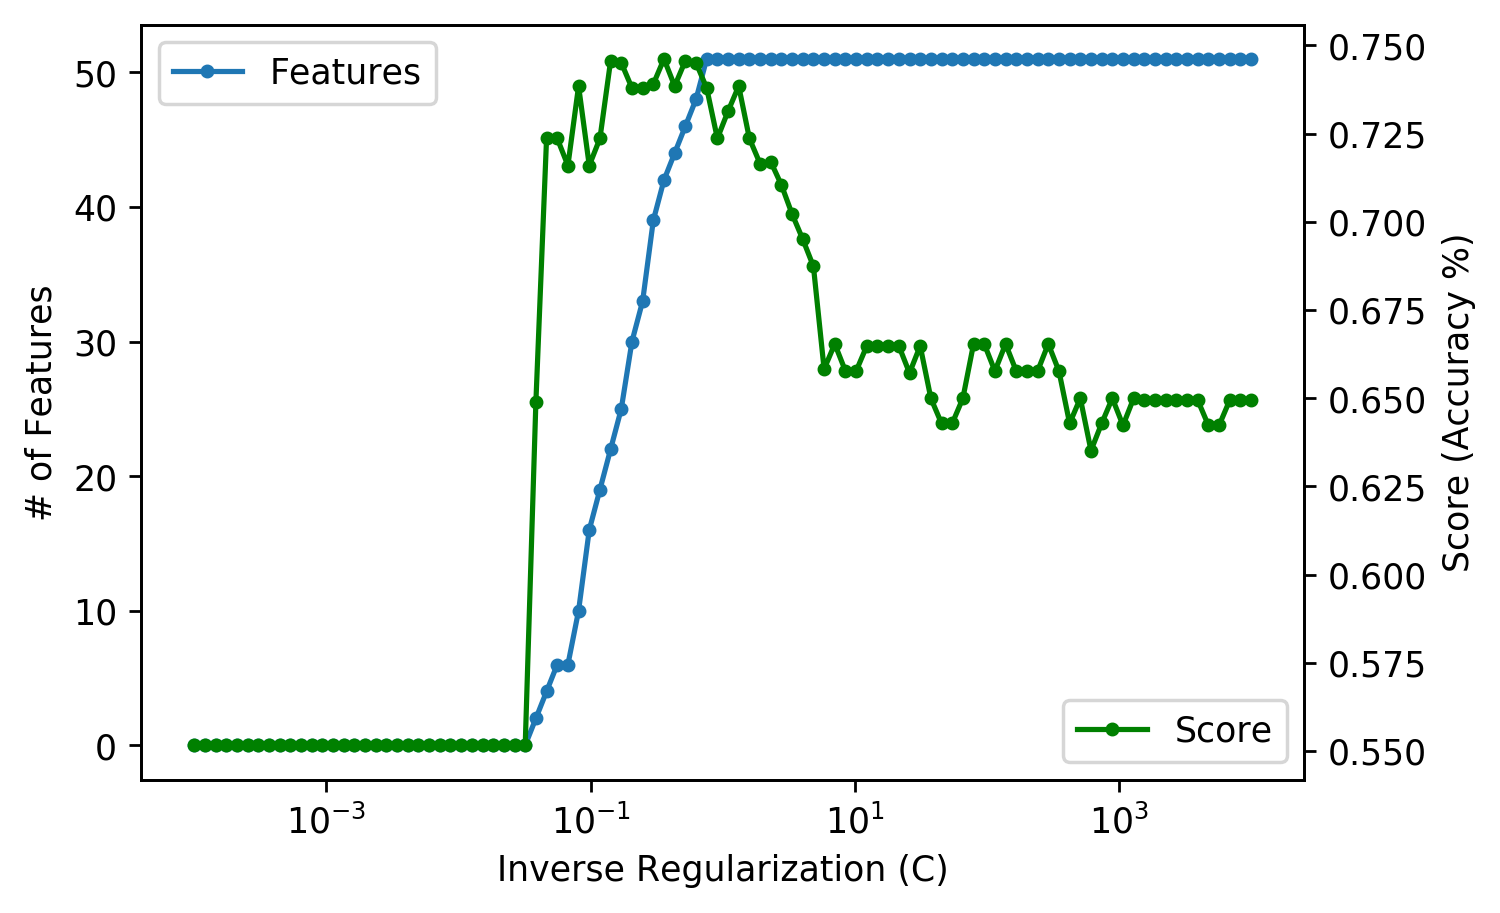

In [26]:
fig, ax1 = plt.subplots()
ax1.set_xscale("log")
ax2 = plt.twinx()

ax1.plot(
    model_performance_df.C.tolist(),
    model_performance_df.feat_num.tolist(),
    label="Features",
    marker=".",
)
ax1.set_ylabel("# of Features")
ax1.set_xlabel("Inverse Regularization (C)")
ax1.legend(loc=0)

ax2.plot(
    model_performance_df.C.tolist(),
    model_performance_df.score.tolist(),
    label="Score",
    marker=".",
    color="green",
)
ax2.set_ylabel("Score (Accuracy %)")
ax2.legend(loc=4)
# plt.savefig("output/preprint_classifier_results.png")

In [27]:
plot_path = list(
    zip(
        model.Cs_,
        model.scores_["polka"].transpose(),
        model.coefs_paths_["polka"].transpose(1, 0, 2),
    )
)

In [28]:
data_records = []
for cs in plot_path[33:40]:
    model = LogisticRegression(C=cs[0], max_iter=1000, penalty="l1", solver="liblinear")
    model.fit(
        StandardScaler().fit_transform(dataset_df[[f"pc{idx+1}" for idx in range(50)]]),
        dataset_df["label"],
    )
    data_records.append(
        {
            "C": cs[0],
            "PCs": ",".join(map(str, model.coef_.nonzero()[1] + 1)),
            "feat_num": len(model.coef_.nonzero()[1]),
            "accuracy": cs[1].mean(),
        }
    )

In [29]:
model_coefs_df = pd.DataFrame.from_records(data_records)
model_coefs_df

,C,PCs,feat_num,accuracy
0,0.046416,"12,43",2,0.723626
1,0.055908,"1,12,43,44,47",5,0.723626
2,0.067342,"1,12,43,44,47",5,0.715934
3,0.081113,"1,6,10,12,43,44,47",7,0.738462
4,0.097701,"1,6,10,11,12,36,43,44,47",9,0.715934
5,0.117681,"1,2,6,10,11,12,36,43,44,47",10,0.723626
6,0.141747,"1,2,4,6,10,11,12,36,43,44,46,47",12,0.745604
